# Modified Unified SAXS/WAXS Data Reduction
This notebook combines azimuthal and radial integration functionality from reduce_pyFAI-linkam and Reduce_Normalise_bl17_2_v3

In [258]:
import os
import glob
import numpy as np
import pyFAI
import matplotlib.pyplot as plt
import tifffile
import fabio
import h5py
import json
from tqdm import tqdm
from joblib import Parallel, delayed
from pathlib import Path
from collections import OrderedDict
from functools import reduce
import operator
from natsort import natsorted, os_sorted
import pandas as pd
from dateutil import parser
import re

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 50})

## Utility Functions 1

In [259]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)
    axs.minorticks_on()
    axs.set_facecolor('white')
    for key in axs.spines:
        axs.spines[key].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)
    return axs

def sort_files(filenames):
    def extract_numbers(filename):
        match = re.search(r'_s(\\d+)_0*(\\d+)', filename)
        if match:
            snumber = int(match.group(1))
            number = int(match.group(2))
            return snumber, number
        return float('inf'), float('inf')
    return sorted(filenames, key=extract_numbers)





import os
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from pytools import F

def plot_2d_images(image, poni_file, output_folder, file_label,
                   azm_range, q_range_2D, mode='azimuthal',
                   vmin=None, vmax=None, log_scale=False, normalize=False):
    """
    Plot 2D scattering image in q-space with azimuthal or radial sector overlay
    and save the figure in a "Figures" subfolder with distinct filenames.

    Parameters
    ----------
    image : 2D np.ndarray
        Detector image.
    poni_file : str
        Path to PONI calibration file.
    output_folder : str
        Base directory where "Figures" subfolder will be created.
    file_label : str
        Base label for the saved figure filename.
    azm_range : tuple
        Azimuthal angle range (degrees) for overlay.
    q_range_2D : tuple
        q-range (nm^-1) for overlay.
    mode : str
        'azimuthal' or 'radial' overlay mode.
    vmin, vmax : float
        Color scaling for the plot.
    log_scale : bool
        Apply log(1 + intensity) transformation.
    normalize : bool
        Normalize image intensity by total counts.
    """

    # Load calibration
    ai = pyFAI.load(poni_file)
    beamx = ai.getFit2D()['centerX']
    beamy = ai.getFit2D()['centerY']
    wavelength = ai.wavelength
    pixel_size = ai.pixel1
    dist = ai.dist

    # Coordinate grid
    ny, nx = image.shape
    x_coords = np.arange(nx) - beamx
    y_coords = np.arange(ny) - beamy
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Reciprocal space
    qx = 1e-9 * 2 * np.pi / wavelength * np.sin(pixel_size * xx / dist)
    qy = 1e-9 * 2 * np.pi / wavelength * np.sin(pixel_size * yy / dist)

    # Process image
    img_proc = np.nan_to_num(image, nan=0.0)
    if normalize:
        total_intensity = np.sum(img_proc)
        if total_intensity > 0:
            img_proc = img_proc / total_intensity
    if log_scale:
        img_proc = np.log1p(img_proc)

    # Masks
    azimuthal_angles = np.degrees(np.arctan2(qy, qx))
    mask_azm = (azimuthal_angles >= azm_range[0]) & (azimuthal_angles <= azm_range[1])
    q_magnitude = np.sqrt(qx**2 + qy**2)
    mask_q = (q_magnitude >= q_range_2D[0]) & (q_magnitude <= q_range_2D[1])

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.pcolormesh(qx, qy, img_proc, cmap='jet', vmin=vmin, vmax=vmax, shading='auto', rasterized=True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Overlay masks
    if mode == 'azimuthal':
        ax.contour(qx, qy, mask_azm, levels=[0.5], colors='white', linewidths=1.5, linestyles='dotted')
    elif mode == 'radial':
        ax.contour(qx, qy, mask_q, levels=[0.5], colors='white', linewidths=1.5, linestyles='dotted')

    # Labels and colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, label='Intensity [a.u.]')
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.yaxis.label.set_size(20)
    
    ax.set_xlabel(r"$q_x$ [nm$^{-1}$]", fontsize=20)
    ax.set_ylabel(r"$q_y$ [nm$^{-1}$]", fontsize=20)
    # remove .tif from file lavel
    if file_label.endswith('.tif'):
        file_label = file_label[:-4]

    ax.set_title(f"{file_label}_2D", fontsize=14, y=1.05)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5)

    # Ensure Figures folder exists
    #output_fig_folder = os.path.join(output_folder, "Figures")
    #os.makedirs(output_fig_folder, exist_ok=True)

    # Append mode to filename
    save_path = os.path.join(output_folder, f"{file_label}_{mode}.png")
    plt.savefig(save_path)#, dpi=300, bbox_inches="tight")
    plt.close(fig)

    return save_path

## Unitiy Functions 2 

In [260]:
import os
import glob
import pandas as pd

def read_csv_metadata(file_path_or_full_path, file_name=None):
    """
    Reads a CSV file and extracts metadata timestamps.
    Automatically detects delimiter (comma or tab) and cleans column names.
    """
    if file_name is None:
        full_path = file_path_or_full_path
    else:
        full_path = os.path.join(file_path_or_full_path, file_name)
    
    # Try reading CSV with comma separator
    df = pd.read_csv(full_path, sep=',', engine='python', skipinitialspace=True)
    
    # Clean column names: strip spaces and lowercase
    df.columns = df.columns.str.strip().str.lower()
    
    # Detect metadata column (last column)
    metadata_col = df.columns[-1]
    metadata = pd.to_datetime(df[metadata_col], errors='coerce', format='%a %b %d %H:%M:%S %Y')
    
    return df, metadata

# ---------------- Example Usage ----------------
folder = 'linkam'
keyword = 'Run4_LDPE_30C_50ums_scan1'

h5_pattern = os.path.join(base_path, folder, f'*{keyword}.csv')
h5_files = glob.glob(h5_pattern)
print("Found files:", h5_files)

if len(h5_files) == 0:
    raise FileNotFoundError(f"No CSV files found for pattern {h5_pattern}")

csv_file = h5_files[0]

df, metadata = read_csv_metadata(csv_file)
print("Metadata head:")
print(metadata.head())
print("Columns in CSV:")
print(df.columns.tolist())

# Access columns safely
cols_to_get = ['i0', 'i1', 'i2', 'photod', 'pd13']
found_cols = [c for c in df.columns if c in cols_to_get]
print("Found columns:", found_cols)
print(df[found_cols].head())


Found files: ['/Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani/linkam/Run4_LDPE_30C_50ums_scan1.csv']
Metadata head:
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: date, dtype: datetime64[ns]
Columns in CSV:
['#', 'time', 'seconds', 'i0', 'i1', 'i2', 'photod', 'eig4m', 'eig1m', 'ni7', 'mpf-spear', 'mpf-ssrl', 'mpf-uppr', 'mpf-lowr', 'normalized', 'foil status', 'pd1', 'pd2', 'pd3', 'pd4', 'pd5', 'pd6', 'pd7', 'pd8', 'pd9', 'pd10', 'pd11', 'pd12', 'pd13', 'pd14', 'pd15', 'pd16', 'icrxt', 'ocrxt', 'roi1', 'roi2', 'roi3', 'roi4', 'roi5', 'roi6', 'roi7', 'ctemp', 'ctempb', 'timer', 'eigroi', 'eigmax', 'eigsum', 'x3_roi1', 'x3_roi2', 'x3_roi3', 'x3_roi4', 'x3_roi5', 'x3_roi6', 'x3_roi7', 'x3_roi8', 'takacs1', 'date']
Found columns: ['i0', 'i1', 'i2', 'photod', 'pd13']
        i0       i1       i2   photod                      pd13
0  0.78318  0.02393  0.00188  0.03183  Sat May 24 12:31:26 2025
1  0.78296  0.02391  0.00189  0.03152  Sat May 24 12:31:28 2025
2  0.78324  0.024

## TIFF Data Reading Functions

In [261]:
def get_tiff_img_data(fname):
    with tifffile.TiffFile(fname) as tif:
        for idx, page in enumerate(tif.pages):
            if idx == 0:
                img_data = page.asarray().astype(float)
            else:
                img_data = np.concatenate((img_data, page.asarray().astype(float)))
    img_data[img_data > 1e8] = np.nan
    return img_data

def get_tiff_meta_data(fname, df=None): 
    meta_dict = dict()
    with tifffile.TiffFile(fname) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            if name in meta_dict.keys():
                name += '_'
            try:
                meta_dict[name] = json.loads(value)
            except:
                pass 

    # Get motor scanned
    scan_motor = meta_dict['ImageDescription']['SPEC']['SCAN_COLS']['0']

    # Get time when image acquired
    series_start_time = meta_dict['ImageDescription']['Eiger_metadata']['series_date']
    series_start_time = parser.parse(series_start_time).timestamp()
    img_start_time = series_start_time + meta_dict['ImageDescription']['Eiger_metadata']['start_time']
    
    full_dict = {'timestamp' : img_start_time, 'scan_motor': scan_motor}
    
    try:
        motor_names = meta_dict['ImageDescription']['SPEC']['Motor_names']
    except:
        motor_names = {}
    
    motor_vals = meta_dict['ImageDescription']['SPEC']['A']

    try:
        counter_names = meta_dict['ImageDescription']['SPEC']['Counter_names']
    except:
        counter_names = {}
    counter_vals = meta_dict['ImageDescription']['SPEC']['S']
    
    motors = {mname:mval for ((km, mname), (kv, mval)) in zip(motor_names.items(), motor_vals.items())}
    counters = {cname:cval for ((kc, cname), (kc, cval)) in zip(counter_names.items(), counter_vals.items())}
    
    full_dict.update({**motors, **counters})

    try:
        df = pd.concat([df, pd.DataFrame([full_dict])], ignore_index=True)
    except:
        df = pd.DataFrame([full_dict])
    
    return df

def extract_metadata(metadata_df):
    if isinstance(metadata_df, pd.DataFrame) and len(metadata_df) > 0:
        row = metadata_df.iloc[0]
        timestamp = row.get('timestamp', None)
        i0 = row.get('1', None)  # Assuming '1' is i0
        i1 = row.get('2', None)  # Assuming '2' is i1
        Photod = row.get('4', None)  # Assuming '4' is Photod
        return timestamp, i0, i1, Photod
    else:
        return None, 1.0, 1.0, 1.0  # Default values

## HDF5 Data Reading Functions (from reduce_pyFAI-linkam)

In [262]:
def get_single_image_h5(fname, n, mask=None, threshold=1e7):
    """Read nth frame from EIGER master.h5 via fabio, apply hot-pixel threshold and dead-pixel mask.
    Returns a float image with NaNs where masked/thresholded. Mirrors Linkam IQ path.
    """
    try:
        imgs = fabio.open(fname)
    except Exception:
        return None
    img = imgs.get_frame(n).data.astype(float)
    # hot-pixel threshold to NaN (configurable)
    if threshold is not None:
        img[img > threshold] = np.nan
    # dead-pixel mask to NaN
    if mask is not None:
        img[mask == 1] = np.nan
    return img


def get_nImages(fname):
    """Return number of frames in EIGER master.h5; None if unavailable (signals corrupted scan)."""
    try:
        return fabio.open(fname).nframes
    except Exception:
        return None






## Unified Integration Function

In [263]:
import csv
from email.mime import base
import os
import glob
from cv2 import norm
import numpy as np
import h5py
import pyFAI
import fabio
import tifffile
from tqdm import tqdm
from joblib import Parallel, delayed

def integrate_files_unified(
    base_path, poni_file, mask_file, folder, keyword,
    output_base_path, file_type='tiff', nsave2d=3, azm_range=(-60, 60),
    q1=None, q2=None, vmin=None, vmax=None, plot=False, method='splitpixel',
    npt=4000, threshold=1e8, parallel=False, reprocess=False):
    """
    Corrected and refactored version of the integration routine.

    Notes:
    - Assumes helper functions exist in scope:
      sort_files, get_tiff_img_data, get_tiff_meta_data, extract_metadata,
      plot_2d_images, get_nImages, get_single_image_h5
    - Saves 2D frames from HDF5 as .tif in output folder.
    """

    # ---- Basic checks and initialization ----
    # Load integrator and mask
    ai = pyFAI.load(poni_file)
    mask = fabio.open(mask_file).data  # assume 0/1 or boolean

    # Create output directories (shared for both branches)
    output_folder = os.path.join(output_base_path, 'OneD_integrated_WAXS_01', folder)
    save_figures_folder = os.path.join(output_folder, 'Figures')
    os.makedirs(save_figures_folder, exist_ok=True)

    azimuthal_data = []
    radial_data = []

    # Convert azimuth range to pyFAI-friendly format if necessary
    azm_tuple = tuple(azm_range)

    # -------- TIFF branch --------
    if file_type.lower() == 'tiff':
        # search Threshold folders (support "Threshold 1", "Threshold 2", etc.)
        threshold_folders = glob.glob(os.path.join(base_path, folder, keyword, 'Threshold*'))
        if not threshold_folders:
            raise FileNotFoundError("No Threshold folders found under: "
                                    f"{os.path.join(base_path, folder, keyword)}")

        for threshold_folder in threshold_folders:
            intermediate_folder = os.path.basename(os.path.dirname(threshold_folder))
            tif_files = [f for f in os.listdir(threshold_folder) if f.endswith('.tif') and not f.startswith('._')]
            #tif_files = sort_files(tif_files)

            azimuthal_data = []
            radial_data = []

            for i, tif_file in enumerate(tqdm(tif_files, desc=f'Processing TIFF ({os.path.basename(threshold_folder)})'), start=1):
                file_path = os.path.join(threshold_folder, tif_file)

                # Read image and apply mask
                try:
                    img = get_tiff_img_data(file_path)
                    img = img.copy()
                    img[mask == 1] = 0
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    continue

                # Metadata and normalization
                eiger_metadata_df = get_tiff_meta_data(file_path)
                real_date_time, i0, i1, Photod = extract_metadata(eiger_metadata_df)
                normfactor = Photod * i1 if (Photod is not None and i1 is not None) else 1.0

                # Save 2D plots and/or images at requested frequency
                if i % nsave2d == 0:
                    try:
                        # plot_2d_images should accept (img, poni_file, out_folder, basename, azm_range, vmin, vmax)
                        plot_2d_images(img, poni_file, save_figures_folder, tif_file, azm_tuple, q_range_2D=(q1,q2), mode='azimuthal', vmin=vmin, vmax=vmax)
                        plot_2d_images(img, poni_file, save_figures_folder, tif_file, azm_tuple, q_range_2D=(q1,q2), mode='radial', vmin=vmin, vmax=vmax)


                        #plot_2d_images(image, poni_file, output_folder, tif_file, azm_range, q_range_2D,mode='azimuthal', vmin=None, vmax=None)
                    except Exception as e:
                        print(f"Warning: plotting failed for {tif_file}: {e}")

                # Azimuthal integration
                result = ai.integrate1d(img, npt, error_model='poisson', correctSolidAngle=True,
                                      azimuth_range=azm_tuple, normalization_factor=normfactor,
                                      polarization_factor=0.95, method=method, mask=mask, unit='q_nm^-1')
                # pyFAI returns attributes .radial, .intensity, .sigma for integrate1d result object
                q = result.radial
                I_azimuthal = result.intensity
                error_azm = getattr(result, 'sigma', None)

                azimuthal_data.append((q, I_azimuthal, error_azm, tif_file, real_date_time, i0, i1, Photod))

                # Radial integration (chi)
                chi, I_radial = ai.integrate_radial(
                    img,
                    npt=720,
                    radial_range=(q1, q2),
                    azimuth_range=(-180, 0),
                    mask=mask,
                    normalization_factor=normfactor,
                    correctSolidAngle=True,
                    polarization_factor=0.95,
                    method=method,
                    unit='chi_deg',
                    radial_unit='q_nm^-1'
                )
                radial_data.append((chi, I_radial, tif_file, real_date_time, i0, i1, Photod))

            # Save azimuthal data in HDF5 format
            az_h5_path = os.path.join(output_folder, f'{intermediate_folder}_azimuthal_data.h5')
            with h5py.File(az_h5_path, 'w') as hf:
                for idx, (q, I, err, tif_file, real_date_time, i0, i1, Photod) in enumerate(azimuthal_data):
                    group = hf.create_group(f'data_{idx}')
                    group.create_dataset('q', data=q)
                    group.create_dataset('I', data=I)
                    if err is not None:
                        group.create_dataset('error', data=err)
                    group.create_dataset('filename', data=np.string_(tif_file))
                    group.create_dataset('real_date_time', data=np.string_(str(real_date_time)) if real_date_time else b'')
                    group.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    group.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    group.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)

            # Save radial data in HDF5 format
            rad_h5_path = os.path.join(output_folder, f'{intermediate_folder}_radial_data.h5')
            with h5py.File(rad_h5_path, 'w') as hf:
                for idx, (chi, I, tif_file, real_date_time, i0, i1, Photod) in enumerate(radial_data):
                    group = hf.create_group(f'data_{idx}')
                    group.create_dataset('chi', data=chi)
                    group.create_dataset('I', data=I)
                    group.create_dataset('filename', data=np.string_(tif_file))
                    group.create_dataset('real_date_time', data=np.string_(str(real_date_time)) if real_date_time else b'')
                    group.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    group.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    group.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)

    # -------- HDF5 branch --------
    elif file_type.lower() == 'h5':
        # Find HDF5 master files
        h5_pattern = os.path.join(base_path, folder, f'*{keyword}*_master.h5')
        h5_files = glob.glob(h5_pattern)
        csv_file_path = os.path.join(base_path, folder)

        if not h5_files:
            h5_pattern = os.path.join(base_path, folder, f'{keyword}_master.h5')
            h5_files = glob.glob(h5_pattern)
        if not h5_files:
            raise FileNotFoundError(f"No HDF5 master files found with pattern {h5_pattern}")

        for h5_file in h5_files:
            nframes = get_nImages(h5_file)
            azimuthal_data = []
            radial_data = []

            basename = os.path.basename(h5_file).replace('_master.h5', '')
            
            # Read corresponding CSV for metadata
            # remove _scan00 from basename if exists the replace ti with _scan 
            if '_scan00' in basename:
                csv_file_name = basename.replace('_scan00', '_scan') + '.csv'
            else:
                csv_file_name = basename + '.csv'

            csv_pattern = os.path.join(csv_file_path, csv_file_name)
            csv_files = glob.glob(csv_pattern)
            print("Found files:", csv_files)

            if len(csv_files) == 0:
                raise FileNotFoundError(f"No CSV files found for pattern {csv_pattern}")

            csv_file = csv_files[0]

            df, metadata = read_csv_metadata(csv_file)
            cols_to_get = ['i0', 'i1', 'i2', 'photod', 'pd13']
            found_cols = [c for c in df.columns if c in cols_to_get]

            def integrate_h5_frame(n):
                # get_single_image_h5 should return a numpy array for frame n (already raw detector counts)
                img = get_single_image_h5(h5_file, n, mask, threshold=threshold)
                if img is None:
                    return None

                # Apply mask
                img = img.copy()
                img[mask == 1] = 0



            # --- Extract corresponding metadata ---
                try:
                    row = df.iloc[n]  # metadata row for this frame
                    i0 = float(row['i0']) if 'i0' in df.columns else np.nan
                    i1 = float(row['i1']) if 'i1' in df.columns else np.nan
                    Photod = float(row['photod']) if 'photod' in df.columns else np.nan

                    if 'pd13' in df.columns:
                        real_date_time = row['pd13']
                    elif 'date' in df.columns:
                        real_date_time = pd.to_datetime(row['date'], errors='coerce')
                    else:
                        real_date_time = None
                except Exception as e:
                    print(f"Warning: could not read metadata for frame {n}: {e}")
                    i0, i1, Photod, real_date_time = np.nan, np.nan, np.nan, None

                # Normalization factor
                normfactor = Photod * i1 if (not np.isnan(Photod) and not np.isnan(i1)) else 1.0








                # --- Save 2D frame using same function as TIFF ---
                if (n % nsave2d) == 0:
                    try:
                        out_name = f"{basename}_frame_{n:05d}"
                        #plot_2d_images(img, poni_file, save_figures_folder, out_name, azm_tuple, vmin, vmax)
                        plot_2d_images(img, poni_file, save_figures_folder, out_name, azm_tuple, q_range_2D=(q1,q2), mode='azimuthal', vmin=vmin, vmax=vmax)
                        plot_2d_images(img, poni_file, save_figures_folder, out_name, azm_tuple, q_range_2D=(q1,q2), mode='radial', vmin=vmin, vmax=vmax)

                    except Exception as e:
                        print(f"Warning: plotting failed for frame {n}: {e}")


                # Azimuthal integration
                result = ai.integrate1d(img, npt, correctSolidAngle=True,
                                    azimuth_range=azm_tuple,normalization_factor=normfactor,
                                    polarization_factor=0.95, method=method,
                                    mask=mask, unit='q_nm^-1')
                q = result.radial
                I = result.intensity
                err = getattr(result, 'sigma', None)

                # Radial integration
                chi, I_radial = ai.integrate_radial(
                    img, npt=720, radial_range=(q1, q2), azimuth_range=(-180, 0),
                    mask=mask, correctSolidAngle=True, polarization_factor=0.95,
                    method=method, unit='chi_deg', radial_unit='q_nm^-1')

                return (q, I, err, n, real_date_time, i0, i1, Photod), (chi, I_radial, n, real_date_time, i0, i1, Photod)

            print(f'Processing {os.path.basename(h5_file)} with {nframes} frames...')

            # Parallel or serial execution
            
            if parallel and nframes > 10:
                results = Parallel(n_jobs=-1, require='sharedmem')(
                    delayed(integrate_h5_frame)(n) for n in range(nframes)
                )
            else:
                results = [integrate_h5_frame(n) for n in tqdm(range(nframes), desc='Processing HDF5')]
            
            
            # Collect results
            for res in results:
                if res is None:
                    continue
                azm, rad = res
                azimuthal_data.append(azm)
                radial_data.append(rad)

            # Save azimuthal data to HDF5
        
            az_out = os.path.join(output_folder, f'{basename}_azimuthal_data.h5')
            with h5py.File(az_out, 'w') as h5file:
                for idx, (q, I, err, n, real_date_time, i0, i1, Photod) in enumerate(azimuthal_data):
                    grp = h5file.create_group(f'data_{idx}')
                    grp.create_dataset('q', data=q)
                    grp.create_dataset('I', data=I)
                    if err is not None:
                        grp.create_dataset('error', data=err)
                    grp.create_dataset('frame_index', data=np.int32(n))
                    str_dt = h5py.string_dtype(encoding="utf-8")
                    grp.create_dataset('filename', data=f"{basename}_frame_{n:05d}", dtype=str_dt)
                    grp.create_dataset('real_date_time', data=str(real_date_time) if real_date_time else "", dtype=str_dt)
                    grp.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    grp.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    grp.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)

            # Save radial data to HDF5
            rad_out = os.path.join(output_folder, f'{basename}_radial_data.h5')
            with h5py.File(rad_out, 'w') as h5file:
                for idx, (chi, I_rad, n, real_date_time, i0, i1, Photod) in enumerate(radial_data):
                    grp = h5file.create_group(f'data_{idx}')
                    grp.create_dataset('chi', data=chi)
                    grp.create_dataset('I', data=I_rad)
                    grp.create_dataset('frame_index', data=np.int32(n))
                    str_dt = h5py.string_dtype(encoding="utf-8")
                    grp.create_dataset('filename', data=f"{basename}_frame_{n:05d}", dtype=str_dt)
                    grp.create_dataset('real_date_time', data=str(real_date_time) if real_date_time else "", dtype=str_dt)
                    grp.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    grp.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    grp.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)


    else:
        raise ValueError("file_type must be 'tiff' or 'h5'.")

    print(f'{file_type.upper()} reduction complete. Files saved in {output_folder}')
    return azimuthal_data, radial_data




## Setup and Usage Example

In [264]:
# Setup paths
base_path = Path(r'/Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani')
save_path = base_path #/ 'processed_data'
save_path.mkdir(exist_ok=True)

calib_path = base_path / 'calibration'
#xye_path = save_path / 'xye_data'
#xye_path.mkdir(exist_ok=True) 

calib_file = calib_path / 'LaB6_linkam_15kev.poni'
dp_mask_file1 = calib_path / 'mask_01.edf'

poni_file = str(calib_file)
mask_file = str(dp_mask_file1)
output_base_path = str(save_path)





In [265]:
# Example usage for TIFF files (ex-situ data)
# Uncomment and modify as needed:

# azimuthal_data, radial_data = integrate_files_unified(
#     base_path, poni_file, mask_file, "P3HB", "some_sample_keyword",
#     output_base_path, file_type='tiff', nsave2d=3, azm_range=(-180, 0),
#     q1=9.25, q2=13, vmin=0, vmax=15, plot=True, method='splitpixel', npt=4000
# )

In [266]:
# Example usage for HDF5 files (in-situ/linkam data)

azimuthal_data, radial_data = integrate_files_unified(
    base_path, poni_file, mask_file, "linkam", "Run4_LDPE_30C_50ums_scan001",
    output_base_path, file_type='h5', nsave2d=100, azm_range=(-120, -60),
    q1=14, q2=16, vmin=1, vmax=50, plot=True, method='csr', npt=2000, threshold=1e8, parallel=True) 



Found files: ['/Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani/linkam/Run4_LDPE_30C_50ums_scan1.csv']
Processing Run4_LDPE_30C_50ums_scan001_master.h5 with 60 frames...
H5 reduction complete. Files saved in /Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani/OneD_integrated_WAXS_01/linkam


## Data Loading Functions

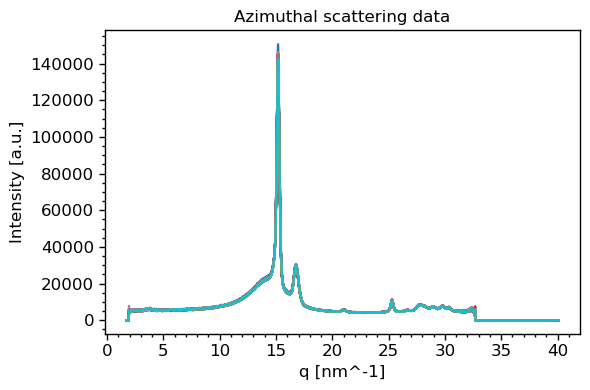

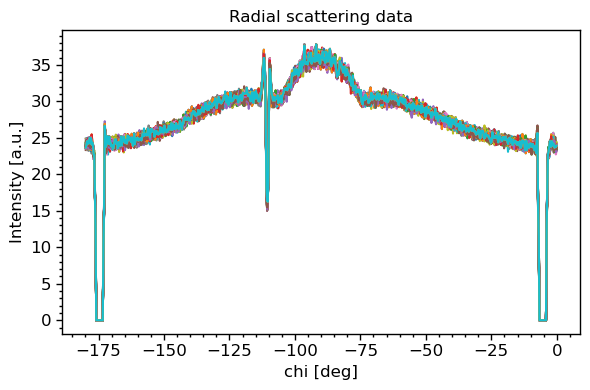

In [267]:
import os
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np

def read_h5_data(base_path, samp_folder, keyword="", azimuthal=True, plot=True):
    """
    Read azimuthal or radial data from HDF5 files generated by integrate_files_unified.
    
    Parameters
    ----------
    base_path : str
        Base directory containing 'OneD_integrated_WAXS_01'.
    samp_folder : str
        Sample folder name under OneD_integrated_WAXS_01.
    keyword : str
        Optional keyword to filter filenames.
    azimuthal : bool
        If True, read azimuthal data; else radial data.
    plot : bool
        If True, automatically plot I(q) or I(chi) for all loaded datasets.
    
    Returns
    -------
    data_list : list of dict
        Each dict contains metadata and arrays ('q'/'chi', 'I', 'error' if available).
    """

    target_folder = os.path.join(base_path, 'OneD_integrated_WAXS_01', samp_folder)
    if not os.path.exists(target_folder):
        raise FileNotFoundError(f"Target folder does not exist: {target_folder}")

    pattern = f"*{keyword}*_azimuthal_data.h5" if azimuthal else f"*{keyword}*_radial_data.h5"
    h5_files = glob.glob(os.path.join(target_folder, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No matching HDF5 files found in {target_folder} with pattern {pattern}")

    data_list = []

    for h5_path in h5_files:
        with h5py.File(h5_path, 'r') as hf:
            for key in hf:
                group = hf[key]
                data = {
                    "filename": group["filename"][()].decode() if isinstance(group["filename"][()], bytes) else group["filename"][()],
                    "real_date_time": group["real_date_time"][()].decode() if isinstance(group["real_date_time"][()], bytes) else group["real_date_time"][()],
                    "i0": group["i0"][()],
                    "i1": group["i1"][()],
                    "Photod": group["Photod"][()]
                }

                if azimuthal:
                    data.update({
                        "q": group["q"][()],
                        "I": group["I"][()],
                        "error": group["error"][()] if "error" in group else None
                    })
                else:
                    data.update({
                        "chi": group["chi"][()],
                        "I": group["I"][()]
                    })
                data_list.append(data)

    # Optional plotting
    if plot and data_list:
        fig, ax = plt.subplots(figsize=(6, 4))
        for data in data_list:
            x = data['q'] if azimuthal else data['chi']
            y = data['I']
            ax.plot(x, y, label=data['filename'])
        ax.set_xlabel("q [nm^-1]" if azimuthal else "chi [deg]")
        ax.set_ylabel("Intensity [a.u.]")
        ax.set_title(f"{'Azimuthal' if azimuthal else 'Radial'} scattering data")
        set_plot_style(ax, fonts=12, xlabel=ax.get_xlabel(), ylabel=ax.get_ylabel())
        #ax.legend(fontsize=8)
        #ax.grid(True)
        plt.tight_layout()
        plt.show()

    return data_list


# Example usage:
base_path = r'/Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani'
samp_folder = 'linkam'
keyword = 'Run4_LDPE_30C_50ums_scan001'
data = read_h5_data(base_path, samp_folder, keyword, azimuthal=True, plot=True)
data_radial = read_h5_data(base_path, samp_folder, keyword, azimuthal=False, plot=True)




## Plotting Functions

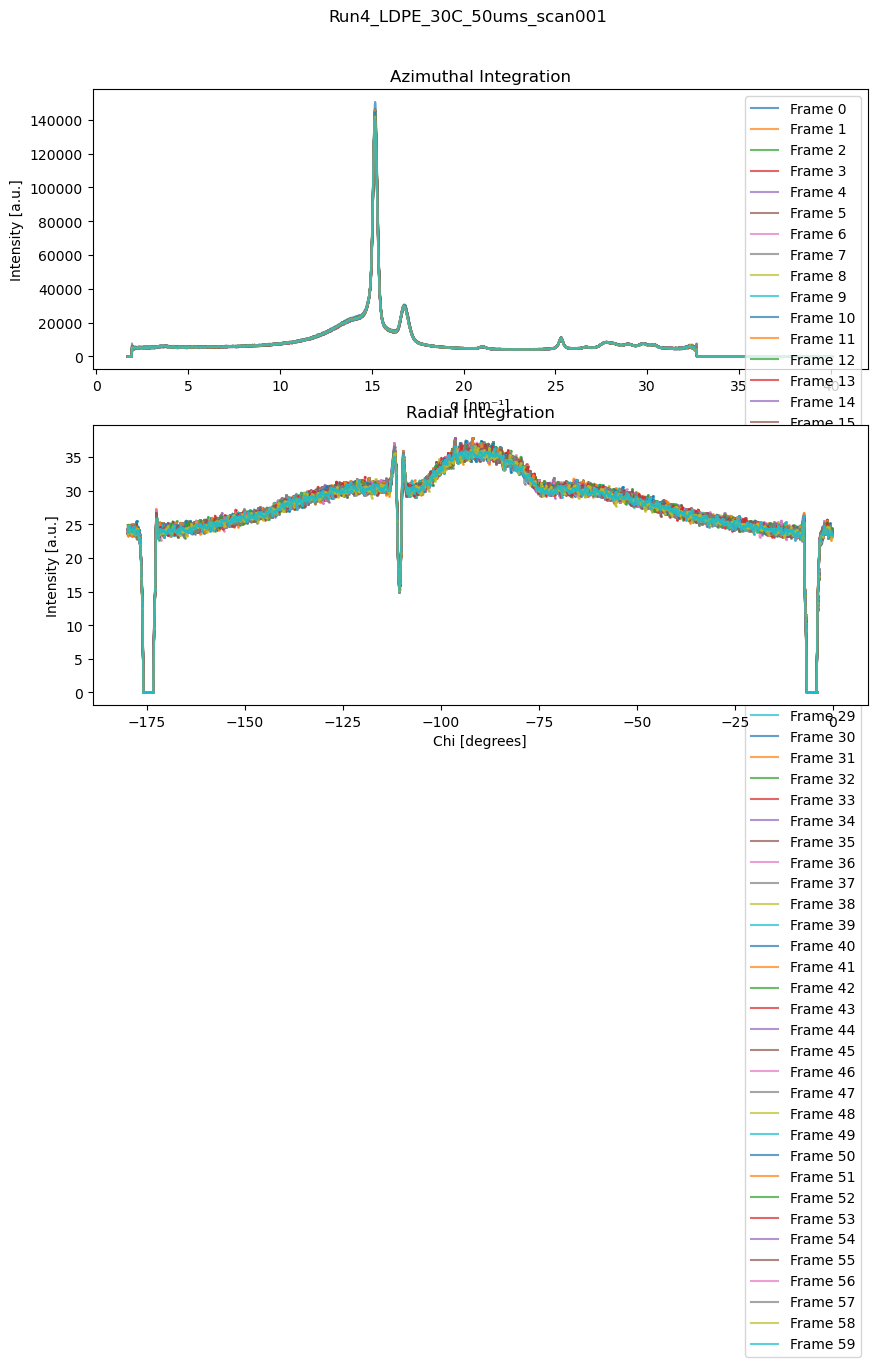

In [268]:
def plot_integrated_data(azimuthal_data, radial_data, title="Integrated Data"):
    """Plot both azimuthal and radial integration results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot azimuthal data
    for i, (q, I, *_) in enumerate(azimuthal_data):  # Plot first 5 for visibility
        ax1.plot(q, I, label=f'Frame {i}', alpha=0.7)
    
    ax1.set_xlabel('q [nm⁻¹]')
    ax1.set_ylabel('Intensity [a.u.]')
    ax1.set_title('Azimuthal Integration')
    ax1.legend()
    
    # Plot radial data
    for i, (chi, I, *_) in enumerate(radial_data):  # Plot first 5 for visibility
        ax2.plot(chi, I, 'o-', markersize=1, label=f'Frame {i}', alpha=0.7)
    
    ax2.set_xlabel('Chi [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')
    ax2.set_title('Radial Integration')
    #ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Example plotting of the processed data
plot_integrated_data(azimuthal_data, radial_data, title="Run4_LDPE_30C_50ums_scan001")